# Determine FTHR from Fitbit Monitoring
Scan over many days, and determine heart-rate thresholds

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from time import sleep
from scipy.interpolate import interp1d
from fitbit.exceptions import HTTPTooManyRequests
import pandas as pd
import numpy as np
import datetime as dt
import json 
import fitbit
import os

Create the FitBit app

In [2]:
auth_client = fitbit.Fitbit(**json.load(open('client-data.json')))

## Create the Utility Functions
Key functions for processing the heart rate data

In [3]:
def get_data_from_date(date):
    """Load heart rate data from fitbit as DataFrame
    
    :param date: str, date in 'YYYY-MM-DD' format
    :return: Dataframe with columns:
        - value -> int, heart rate
        - time -> datetime, time of day
        - seconds_awake -> float, number of seconds fitbit has recorded this day"""
    
    # Download data from fitbit
    data = auth_client.make_request('https://api.fitbit.com/1/user/-/activities/heart/date/%s/1d/1sec/time/00:00/23:59.json'%date)
    
    # Turn it into a dateframe
    data = pd.DataFrame(data['activities-heart-intraday']['dataset'])
    
    # Pre-compute some useful columns
    data['time'] = pd.to_datetime(data['time'])
    data['seconds_awake'] = (data['time'] - data['time'].min()).dt.total_seconds()
    return data

Get day where I ran a half-marathon

In [4]:
try:
    data = get_data_from_date('2017-09-24')
except HTTPTooManyRequests as exc:
    print(exc.retry_after_secs)

In [5]:
def get_max_heartrate(data, interval_length=5):
    """Get the interval with the highest average heart rate
    
    :param data: DataFrame, data generated from `get_data_from_date`
    :param interval_length: float, heart rate interval in minutes
    :return: float, highest average heart rate"""
    
    return data.set_index('time').rolling('%.2fmin'%interval_length).mean()['value'].max()

Plot my maximum mean heart rate over several different intervals

In [6]:
intervals = [0.05, 0.1, 0.5, 1, 3, 5, 10, 15, 20, 30, 45, 60, 90, 120, 150]

A Jupyter Widget

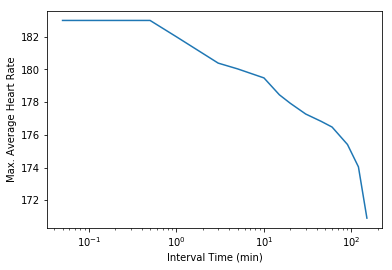

In [7]:
fig, ax = plt.subplots()

ax.semilogx(intervals, [get_max_heartrate(data, i) for i in tqdm(intervals)])

ax.set_ylim(ax.get_ylim())

ax.set_xlabel('Interval Time (min)')
ax.set_ylabel('Max. Average Heart Rate')

## Compute this for All Exercise Dates
Compute the heart rate intervals for all days with a significant exercise

In [8]:
def analyze_data(date, intervals=intervals):
    """Download and analyze heart rates from a certain date
    
    :param date: str, date to be processed
    :param intervals: [float], intervals to be studied
    :return: [float], maximum mean HR for each interval"""
    
    # Download the data
    failures = 0
    while True:
        try:
            data = get_data_from_date(date)
        except HTTPTooManyRequests as exc:
            failures += 1
            if failures > 5:
                raise
            sleep(exc.retry_after_secs)
            continue
        break
    
    # Analyze the intervals
    hr_intervals = [get_max_heartrate(data, i) for i in intervals]
    return hr_intervals

In [9]:
active_dates = json.load(open(os.path.join('data', 'activity-dates.json')))

In [10]:
hr_data = np.array([analyze_data(d) for d in tqdm(active_dates)])

A Jupyter Widget

Compute the maximum HR for each interval. To avoid getting outliers (likely due to equipment problems), pick the second highest.

In [13]:
max_hr = np.array([sorted(h)[-2] for h in hr_data.T])
max_hr_f = interp1d(intervals, max_hr)

In [17]:
print('Maximum HR (over 3s interval):', max_hr.max())

Maximum HR (over 3s interval): 187.0


In [19]:
fthr = max_hr_f(20) * 0.95
print('FTHR (95%% of maximum 20 minute average): %.1f'%fthr)

FTHR (95% of maximum 20 minute average): 172.7


In [21]:
print('1 hour sustained HR: %.1f'%max_hr_f(60))

1 hour sustained HR: 176.5


In [24]:
print('Zone\tMinHR')
for z,h in enumerate([0.68, 0.83, 0.94, 1.05]):
    print('%d\t%.1f'%(z+2, fthr * h))

Zone	MinHR
2	117.4
3	143.3
4	162.3
5	181.3


Plot all of the exercises, and the maximum sustained HRs for each interval

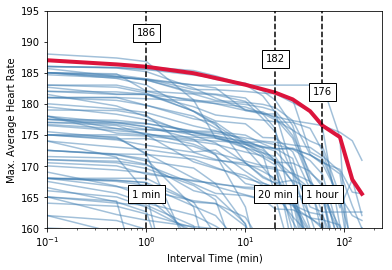

In [29]:
fig, ax = plt.subplots()

# Plot all of the 
for hr_datum in hr_data:
    single, = ax.semilogx(intervals, hr_datum, color='steelblue', alpha=0.5)

maximum, = ax.semilogx(intervals, max_hr, color='crimson', lw=4)

ax.set_ylim(160, 195)
ax.set_xlim(0.1, 240)

# Plot the 1, 20, and 60 minute HR
for t,v in zip([1, 20, 60], ['1 min', '20 min', '1 hour']):
    ax.semilogx([t,t], ax.get_ylim(), 'k--')
    ax.text(t, max_hr_f(t) + 5, '%.0f'%max_hr_f(t), ha='center',
           bbox={'facecolor':'w', 'edgecolor':'k'})
    ax.text(t, 165, v, ha='center',
           bbox={'facecolor':'w', 'edgecolor':'k'})
    
ax.set_xlabel('Interval Time (min)')
ax.set_ylabel('Max. Average Heart Rate')

Light blue lines are the HR curves for each activity. The red line is the maximum curve. Specific time intervals and their corresponding HR are shown with vertical dashed lines